In [1]:
import numpy as np

from kafka_infra.MongoDbClient import MongoDbClient

client = MongoDbClient("autoencoder_recognized_samples")

In [2]:
domain = np.arange(-1, 1, 0.02)

In [3]:
def define_pipeline(x):
    pipeline = [
        {
            "$lookup": {
                "from": "generated_samples",
                "localField": "sample_id",
                "foreignField": "sample_id",
                "as": "generated_sample_data"
            }
        },
        {
            "$unwind": "$generated_sample_data"
        },
        {
            "$project": {
                "sample_id": 1,
                "predicted_value": 1,
                "duration": 1,
                "normal_data": "$generated_sample_data.normal_data"
            }
        },
        {
            "$facet": {
                "normal_data_total": [
                    {
                        "$match": {
                            "normal_data": 1
                        }
                    },
                    {
                        "$count": "count"
                    }
                ],
                "normal_data_recognized": [
                    {
                        "$match": {
                            "normal_data": 1,
                            "predicted_value": { "$gte": x }
                        }
                    },
                    {
                        "$count": "count"
                    }
                ],
                "anomalous_data_total": [
                    {
                        "$match": {
                            "normal_data": 0
                        }
                    },
                    {
                        "$count": "count"
                    }
                ],
                "anomalous_data_recognized": [
                    {
                        "$match": {
                            "normal_data": 0,
                            "predicted_value": { "$lt": x }
                        }
                    },
                    {
                        "$count": "count"
                    }
                ]
            }
        },
        {
            "$project": {
                "normal_data_count": { "$arrayElemAt": ["$normal_data_total.count", 0] },
                "correct_recognized_normal_data": { "$arrayElemAt": ["$normal_data_recognized.count", 0] },
                "anomalous_data_count": { "$arrayElemAt": ["$anomalous_data_total.count", 0] },
                "correct_recognized_anomalous_data": { "$arrayElemAt": ["$anomalous_data_recognized.count", 0] }
            }
        }
    ]

    return pipeline


In [4]:
sample_details = []
normal_data_count = -1
anomalous_data_count = -1

In [5]:
for x in domain:
    pipeline = define_pipeline(x)
    result = client.aggregate(pipeline)
    for doc in result:
        if normal_data_count == -1:
            normal_data_count = doc['normal_data_count']
        if anomalous_data_count == -1:
            anomalous_data_count = doc['anomalous_data_count']
        try:
            doc['correct_recognized_normal_data']
        except KeyError:
            doc['correct_recognized_normal_data'] = 0
        try:
            doc['correct_recognized_anomalous_data']
        except KeyError:
            doc['correct_recognized_anomalous_data'] = 0
        sample_details.append({
            'factor': x,
            'correct_recognized_normal_data': doc['correct_recognized_normal_data'],
            'correct_recognized_anomalous_data': doc['correct_recognized_anomalous_data']
        })

In [6]:
correct_recognized_normal_samples_ratio = []
correct_recognized_anomalous_samples_ratio = []

for sample in sample_details:
    correct_recognized_normal_samples_ratio.append(sample['correct_recognized_normal_data']/normal_data_count)
    correct_recognized_anomalous_samples_ratio.append(sample['correct_recognized_anomalous_data']/anomalous_data_count)

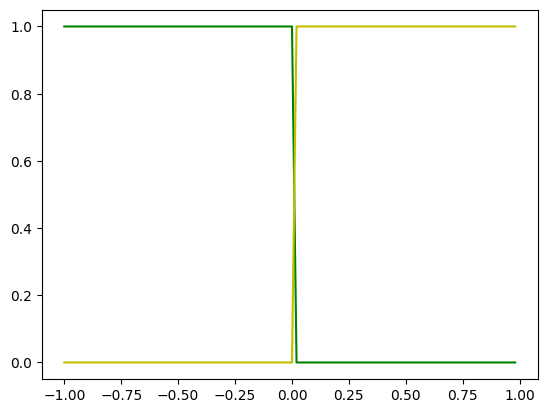

In [7]:
import matplotlib.pyplot as plt

plt.plot(domain, correct_recognized_normal_samples_ratio, 'g')
plt.plot(domain, correct_recognized_anomalous_samples_ratio, 'y')
plt.show()

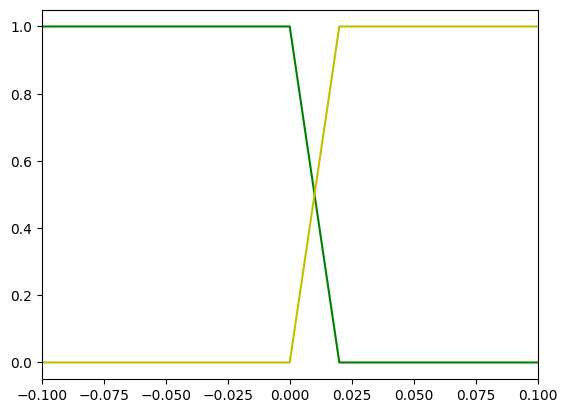

In [8]:
plt.plot(domain, correct_recognized_normal_samples_ratio, 'g')
plt.plot(domain, correct_recognized_anomalous_samples_ratio, 'y')
plt.xlim(-0.1, 0.1)
plt.show()

In [11]:
min_difference = float('inf')
for i in range(0, len(correct_recognized_normal_samples_ratio)):
    # Compute the absolute difference between the current pair of values
    difference = abs(correct_recognized_normal_samples_ratio[i] - correct_recognized_anomalous_samples_ratio[i])

    # Check if this pair is closer than the previously found closest pair
    if difference < min_difference:
        # If so, update the closest pair and the minimum difference
        closest_pair = (correct_recognized_normal_samples_ratio[i], correct_recognized_anomalous_samples_ratio[i])
        index = i
        min_difference = difference

print(index)
print(np.mean(closest_pair))

0
0.5
